<a id='top'> </a>
Author: [James Bourbeau](http://www.jamesbourbeau.com)

In [5]:
%load_ext watermark
%watermark -u -d -v -p numpy,scipy,pandas,sklearn,mlxtend

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
last updated: 2017-02-03 

CPython 2.7.10
IPython 5.2.1

numpy 1.12.0
scipy 0.18.1
pandas 0.19.2
sklearn 0.18
mlxtend 0.5.0


# Cosmic-ray composition feature selection
### Table of contents
1. [Data preprocessing](#Data-preprocessing)
2. [Comparison of different sequential feature selections](#Comparison-of-different-sequential-feature-selections)
3. [Serialize feature selection algorithm](#Serialize-feature-selection-algorithm)

In [6]:
import sys
sys.path.append('/home/jbourbeau/cr-composition')
print('Added to PYTHONPATH')

Added to PYTHONPATH


In [7]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cPickle

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import composition as comp
import composition.analysis.plotting as plotting

# # Plotting-related
# sns.set_palette('muted')
# sns.set_color_codes()
# color_dict = {}
# for i, composition in enumerate(['light', 'heavy', 'total']):
#     color_dict[composition] = sns.color_palette('muted').as_hex()[i]
%matplotlib inline

# Data preprocessing
[ [back to top](#top) ]
1. Load simulation/data dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets
4. Feature selection

### Load simulation, format feature and target matrices

In [8]:
df_sim = comp.load_dataframe(datatype='sim', config='IC79')

feature_list, feature_labels = comp.get_training_features()
print('training features = {}'.format(feature_list))
X_train_sim, X_test_sim, y_train_sim, y_test_sim, le = comp.get_train_test_sets(
    df_sim, feature_list, comp_class=True)

print('number training events = ' + str(y_train_sim.shape[0]))
print('number testing events = ' + str(y_test_sim.shape[0]))

sim quality cut event flow:
              lap_reco_success:  0.625  0.625
                    lap_zenith:  0.712   0.59
                 num_hits_1_30:  0.637  0.575
                     IT_signal:  0.227  0.226
                max_qfrac_1_30:   0.77  0.226
               lap_containment:   0.58  0.175
              energy_range_lap:  0.424   0.12
                      llhratio:  0.697  0.119


training features = ['lap_log_energy', 'lap_cos_zenith', 'log_NChannels_1_30', 'nchannels_nhits_ratio', 'lap_rlogl', 'log_NHits_1_30', 'nchannels_nhits_ratio', 'log_s50', 'log_s125', 'log_s500', 'lap_beta', 'llhratio']
number training events = 145105
number testing events = 62188


# Comparison of different sequential feature selections
[ [back to top](#top) ]

In [9]:
pipeline = comp.get_pipeline('xgboost')
# pipeline = comp.get_pipeline('RF')
print('max_depth = {}'.format(pipeline.get_params()['classifier__max_depth']))
n_features_forward = X_train_sim.shape[1]
n_features_backward = 1

max_depth = 3


### SFS&mdash;sequential forward selection

In [10]:
sfs = SFS(pipeline, 
          k_features=2, 
          forward=True, 
          floating=False, 
          scoring='accuracy',
          print_progress=True,
          cv=3,
          n_jobs=15)
sfs = sfs.fit(X_train_sim, y_train_sim)

Features: 2/2

### SBS&mdash;sequential backward selection

In [ ]:
sbs = SFS(pipeline, 
          k_features=n_features_backward, 
          forward=False, 
          floating=False, 
          scoring='accuracy',
          print_progress=True,
          cv=3,
          n_jobs=20)
sbs = sbs.fit(X_train_sim, y_train_sim)

Features: 3/11

### SFFS&mdash;sequential floating forward selection

In [ ]:
sffs = SFS(pipeline, 
          k_features=n_features_forward, 
          forward=True, 
          floating=True, 
          scoring='accuracy',
          print_progress=True,
          cv=3,
          n_jobs=15)
sffs = sffs.fit(X_train_sim, y_train_sim)

### SFBS&mdash;sequential floating backward selection

In [10]:
sfbs = SFS(pipeline, 
          k_features=n_features_backward, 
          forward=False, 
          floating=True, 
          scoring='accuracy',
          print_progress=True,
          cv=3,
          n_jobs=20)
sfbs = sfbs.fit(X_train_sim, y_train_sim)

Features: 1/1

/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


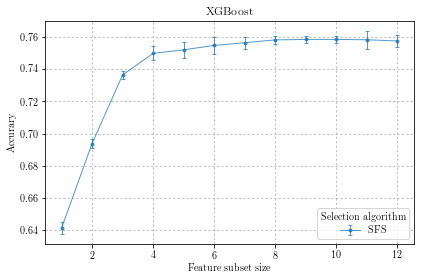

In [7]:
selector_list = [sfs]
# selector_list = [sfs, sffs, sbs, sfbs]
selector_label = {sfs:'SFS'}
# selector_label = {sfs:'SFS', sffs:'SFFS', sbs:'SBS', sfbs:'SFBS'}
fig, ax = plt.subplots()
for selector in selector_list:
    info = selector.get_metric_dict()
    scores = [info[size]['avg_score'] for size in info]
    errs = [info[size]['ci_bound'] for size in info]
    ax.errorbar(info.keys(), scores, yerr=errs,
                marker='.', linestyle='-', lw=1, alpha=0.75, 
                label=selector_label[selector])
plt.xlabel('Feature subset size')
plt.ylabel('Accurary')
plt.title('XGBoost')
# plt.title('Max depth = {}'.format(pipeline.get_params()['classifier__max_depth']))
plt.grid()
plt.legend(title='Selection algorithm', loc='lower right')
plt.show()

In [11]:
for selector in selector_list:
    idx = selector.get_metric_dict()[4]['feature_idx']
    print(idx)
    print(selector_label[selector]+':')
    print(np.sort(feature_labels[list(idx)]))

(8, 10, 11, 5)
SFS:
['$\\log_{10}$(NHits (top 50\\%))' '$\\log_{10}(S_{\\mathrm{125}})$'
 'lap beta' 'llhratio']


In [22]:
sfs.get_metric_dict()

{1: {'avg_score': 0.64260751582929032,
  'ci_bound': 0.0052960477129735048,
  'cv_scores': array([ 0.64018173,  0.64184689,  0.64579393]),
  'feature_idx': (12,),
  'std_dev': 0.0023534544762706193,
  'std_err': 0.0016641436193847896},
 2: {'avg_score': 0.69369295288216437,
  'ci_bound': 0.0018654219293701162,
  'cv_scores': array([ 0.69424801,  0.69252117,  0.69430968]),
  'feature_idx': (12, 5),
  'std_dev': 0.00082895506757898378,
  'std_err': 0.00058615974958405232},
 3: {'avg_score': 0.73737768275635229,
  'ci_bound': 0.0030548736488657841,
  'cv_scores': array([ 0.73894005,  0.7375627 ,  0.73563029]),
  'feature_idx': (10, 12, 5),
  'std_dev': 0.001357522902550993,
  'std_err': 0.00095991365000985189},
 4: {'avg_score': 0.74210591234273504,
  'ci_bound': 0.0024696717687726169,
  'cv_scores': array([ 0.743031  ,  0.7405641 ,  0.74272264]),
  'feature_idx': (4, 10, 12, 5),
  'std_dev': 0.0010974712453777644,
  'std_err': 0.00077602935976386271},
 5: {'avg_score': 0.7452375078803825

In [23]:
sfs.subsets_

{1: {'avg_score': 0.64260751582929032,
  'cv_scores': array([ 0.64018173,  0.64184689,  0.64579393]),
  'feature_idx': (12,)},
 2: {'avg_score': 0.69369295288216437,
  'cv_scores': array([ 0.69424801,  0.69252117,  0.69430968]),
  'feature_idx': (12, 5)},
 3: {'avg_score': 0.73737768275635229,
  'cv_scores': array([ 0.73894005,  0.7375627 ,  0.73563029]),
  'feature_idx': (10, 12, 5)},
 4: {'avg_score': 0.74210591234273504,
  'cv_scores': array([ 0.743031  ,  0.7405641 ,  0.74272264]),
  'feature_idx': (4, 10, 12, 5)},
 5: {'avg_score': 0.74523750788038257,
  'cv_scores': array([ 0.74555958,  0.7435655 ,  0.74658745]),
  'feature_idx': (4, 10, 2, 12, 5)},
 6: {'avg_score': 0.74922566674889668,
  'cv_scores': array([ 0.74938327,  0.74829373,  0.75      ]),
  'feature_idx': (2, 3, 4, 5, 10, 12)},
 7: {'avg_score': 0.75145958391579637,
  'cv_scores': array([ 0.75174739,  0.74981498,  0.75281638]),
  'feature_idx': (1, 2, 3, 4, 5, 10, 12)},
 8: {'avg_score': 0.75178165172820222,
  'cv_scor

In [7]:
print('\nSequential Forward Selection:')
selected_features_str = 'Selected features:\n'
for idx in sfs.k_feature_idx_:
    selected_features_str += r'{}, '.format(feature_labels[idx])
print(selected_features_str)
print('CV Score:')
print(sfs.k_score_)


Sequential Forward Selection:
Selected features:
$\log_{10}(E_{\mathrm{Lap}}/\mathrm{GeV})$, $\log_{10}$(NChannels (top 50\%)), NChannels/NHits, $\log_{10}$(NHits (top 50\%)), $\log_{10}(S_{\mathrm{125}})$, lap beta, 
CV Score:
0.734951895403


# Serialize feature selection algorithm
[ [back to top](#top) ]

In [35]:
pipeline = comp.get_pipeline('xgboost')
# pipeline = comp.get_pipeline('RF')
max_depth = pipeline.get_params()['classifier__max_depth']
n_features_forward = 7

### SFS&mdash;sequential forward selection

In [36]:
sfs_pickle = SFS(pipeline, 
          k_features=n_features_forward, 
          forward=True, 
          floating=False, 
          scoring='accuracy',
          print_progress=True,
          cv=3,
          n_jobs=15)
sfs_pickle = sfs_pickle.fit(X_train_sim, y_train_sim)

Features: 7/7

Serialize `sfs` for later use (fitting procedure takes quite a while)

In [37]:
with open('feature-selection/sfs_nfeatures_{}_xgboost.pkl'.format(n_features_forward), 'wb') as f_obj:
    cPickle.dump(sfs_pickle, f_obj, protocol=cPickle.HIGHEST_PROTOCOL)    

### SBS&mdash;sequential backward selection

In [ ]:
sbs_pickle = SFS(pipeline, 
          k_features=5, 
          forward=False, 
          floating=False, 
          scoring='accuracy',
          print_progress=True,
          cv=3,
          n_jobs=15)
sbs_pickle = sbs_pickle.fit(X_train_sim, y_train_sim)

Features: 11/5Process PoolWorker-4678:
Process PoolWorker-4679:
Process PoolWorker-4677:
Process PoolWorker-4675:
Process PoolWorker-4676:
Traceback (most recent call last):
Process PoolWorker-4684:
Process PoolWorker-4682:
Process PoolWorker-4685:
Process PoolWorker-4683:
Process PoolWorker-4680:
Process PoolWorker-4681:
Process PoolWorker-4674:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/cvmfs/icecube.opensciencegrid.

Serialize `sfs` for later use (fitting procedure takes quite a while)

In [37]:
with open('feature-selection/sfs_nfeatures_{}_xgboost.pkl'.format(n_features_forward), 'wb') as f_obj:
    cPickle.dump(sfs_pickle, f_obj, protocol=cPickle.HIGHEST_PROTOCOL)    

### SFFS&mdash;sequential floating forward selection

In [23]:
sffs = SFS(pipeline, 
          k_features=n_features_forward, 
          forward=True, 
          floating=True, 
          scoring='accuracy',
          print_progress=True,
          cv=3,
          n_jobs=20)
sffs = sffs.fit(X_train_sim, y_train_sim)

Features: 8/8

Serialize `sffs` for later use (fitting procedure takes quite a while)

In [24]:
with open('feature-selection/sffs_nfeatures_{}.pkl'.format(n_features_forward), 'wb') as f_obj:
    cPickle.dump(sffs, f_obj, protocol=cPickle.HIGHEST_PROTOCOL)    